# Neural Networks Project - Clothing Items Image Classification (Fashion Mnist from Zalando)

It takes approx. 30-40 minutes to run the entire notebook in Google Colab using CPU
- This can be made faster by reducing the number of epochs or training examples

**Completed by**: Martin Kašperlík

## 1. Introduction to the Problem

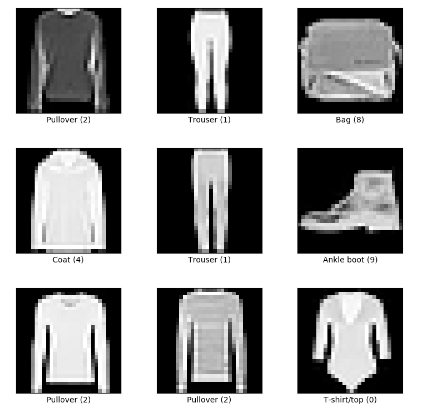


Accurate image classification plays an important role in shaping the success of businesses like Zalando. This technology elevates customer satisfaction by delivering personalized product recommendations and streamlining the shopping journey with improved search functionalities.

It also aids in maintaining efficient inventory levels, allowing Zalando to respond effectively to customer demands. The ability to tailor marketing strategies based on precise classifications enables targeted promotions, while the reduction in return rates enhances operational efficiency.

In the competitive landscape of fashion retail, Zalando's commitment to accurate item classification not only minimizes costs but also solidifies its position as an industry leader.

Our task is to build a Neural Networks model such that we can correctly classify the object on the image.

## 2. Dataset Description

**Dataset source**: https://www.tensorflow.org/datasets/catalog/fashion_mnist

**Dataset description**: Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Each image pixel has a grayscale value from 0 to 255 (0 = as dark as possible, 255 = as light as possible)

Here's an example of what the data looks (each class takes three-rows):

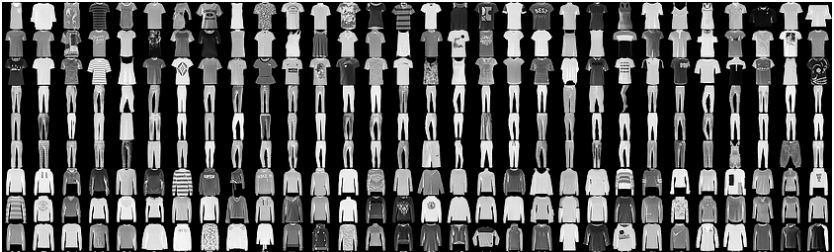

There are 10 different fashion categories. Each image belongs to one of the following classes:



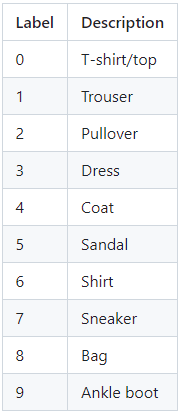

In [106]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## 3. Package Imports

In [107]:
pip install -q -U keras-tuner

In [108]:
# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from kerastuner.tuners import RandomSearch

# Other Useful Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## 4. Loading and Exploring the Dataset

In [109]:
# This specific dataset is available in the keras.datasets, so we can just load it from there
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [110]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [111]:
X_train.shape

(60000, 28, 28)

In [112]:
X_test.shape

(10000, 28, 28)

In [113]:
y_test.shape

(10000,)

In [114]:
y_train.shape

(60000,)

In [115]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Each label is a value between 0 and 9.

Text(0.5, 0, 'Ankle boot')

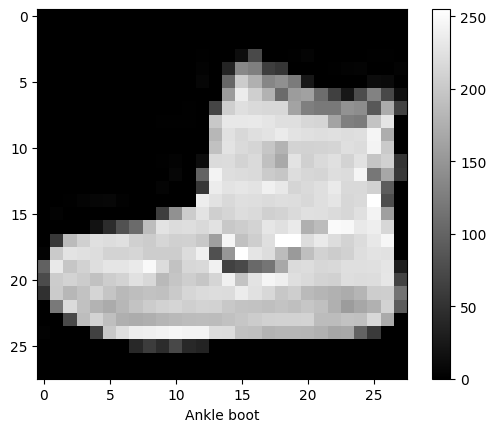

In [116]:
plt.figure
plt.imshow(X_train[0], cmap = "gray")
plt.colorbar()
plt.xlabel(class_names[y_train[0]])

Showing the first 10 training data pictures and their labels:

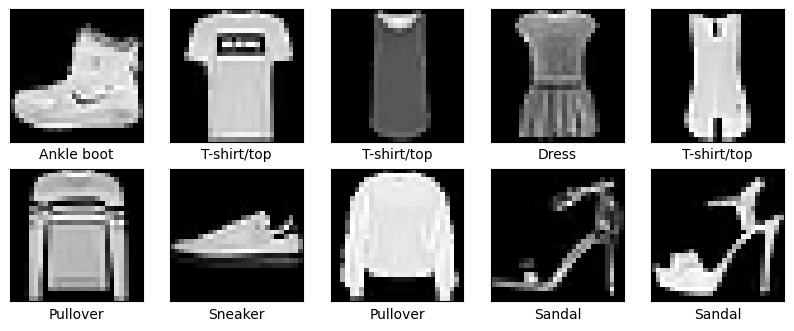

In [117]:
plt.figure(figsize = (10, 10))
for image in range(10):
  plt.subplot(5, 5, image+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train[image], cmap = "gray")
  plt.xlabel(class_names[y_train[image]])

## 5. Data Preprocessing

### 5.1. Normalisation (Min-Max Scaling)

It is better to work with very small values between 0 and 1  for the models)

In [118]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### 5.2. Converting 2D Matrix input into 1D Array input

Neural Network models require its input data to be converted into a 1D array)

This 1D array will have 28*28 = 784 elements

In [119]:
train_size = X_train.shape[0] # 60000 training images of size 28 x 28
test_size = X_test.shape[0]   # 10000 testing images of size 28 x 28

X_train = X_train.reshape((train_size, 28 * 28))
X_test = X_test.reshape((test_size, 28 * 28))

**Note** - Using ".reshape()" is the same as using the "Flatten" layer in the network. You have to use one method or the other (not both)

### 5.3. Converting Target Labels Using One-Hot Encoding

The model's output layer will have 10 units, indicating that it expects a one-hot encoded representation of the target labels for multi-class classification

In [120]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 6. Building Different Neural Network Architectures

In [121]:
# Setting a random seed for reproducible results:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

### 6.1. Feedforward Neural Network

Now, we will try different kinds of architectures to see which one performs the best.

Model Specification:

In [122]:
# Model 1 = Simple NN with 2 hidden layers:
inputs = keras.Input(shape = (28 * 28, ))               # The input shape is a 1d array containing 28 x 28 = 784 elements
x1 = layers.Dense(256, activation = "relu")(inputs)     # 1st Hidden layer
x2 = layers.Dense(128, activation = "relu")(x1)         # 2nd Hidden layer
outputs = layers.Dense(10, activation = "softmax")(x2)  # Output layer with 10 nodes (because we have 10 possible classification options)
model1 = keras.Model(inputs = inputs, outputs = outputs)

In [123]:
# Model 2 = Simple NN with Dropout regularization
inputs = keras.Input(shape = (28 * 28, ))
x1 = layers.Dense(256, activation = "relu")(inputs)     # 1st Hidden layer
x2 = layers.Dropout(0.4)(x1)                            # Regularization (Dropout) layer
x3 = layers.Dense(128, activation = "relu")(x2)         # 2nd Hidden layer
x4 = layers.Dropout(0.3)(x3)                            # Regularization (Dropout) layer
x5 = layers.Dense(64, activation = "relu")(x4)          # 3rd Hidden layer
x6 = layers.Dropout(0.3)(x5)                            # Regularization (Dropout) layer
outputs = layers.Dense(10, activation = "softmax")(x6)  # Output layer with 10 nodes (because we have 10 possible classification options)
model2 = keras.Model(inputs = inputs, outputs = outputs)

In [124]:
# Model 3 = Simple NN with L1 regularization
inputs = keras.Input(shape = (28 * 28, ))
x1 = layers.Dense(256, activation = "relu", kernel_regularizer = keras.regularizers.l1(0.01))(inputs)  # 1st Hidden layer with L1 regularization
x2 = layers.Dense(128, activation = "relu", kernel_regularizer = keras.regularizers.l1(0.01))(x1)      # 2nd Hidden layer with L1 regularization
outputs = layers.Dense(10, activation = "softmax")(x2)                                                 # Output layer with 10 nodes (because we have 10 possible classification options)
model3 = keras.Model(inputs = inputs, outputs = outputs)

In [125]:
# Model 4 = Simple NN with L2 regularization
inputs = keras.Input(shape = (28 * 28, ))
x1 = layers.Dense(256, activation = "relu", kernel_regularizer = keras.regularizers.l2(0.01))(inputs)  # 1st Hidden layer with L2 regularization
x2 = layers.Dense(128, activation = "relu", kernel_regularizer = keras.regularizers.l2(0.01))(x1)      # 2nd Hidden layer with L2 regularization
outputs = layers.Dense(10, activation = "softmax")(x2)                                                 # Output layer with 10 nodes (because we have 10 possible classification options)
model4 = keras.Model(inputs = inputs, outputs = outputs)

In [126]:
models = [model1, model2, model3, model4]

Model Compilation:

In [127]:
# We should use "categorical_crossentropy" loss function for classification models !!!
# using "categorical_crossentropy" also suggests that the target labels should be in one-hot encoded format (done using "to_categorical()") !!!
for i, model in enumerate(models, start = 1):
    print(f"Compiling and summarizing Model {i}:")
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    model.summary()

Compiling and summarizing Model 1:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Compiling and summarizing Model 2:
Model: "model_3"
________________________________________________________________

Fitting the Models:

In [128]:
# Takes approx. 4-5 min. on CPU
model_results = []
for model in models:
  epochs = 20 # Nr. of epochs the model will perform
  # An epoch refers to one complete pass through the entire training dataset
  # During each epoch, the model iteratively updates its weights based on the training examples, moving towards minimizing the defined loss function
  batch_size = 128 # Nr. of training examples utilized in one iteration
  early_stopping_monitor = EarlyStopping(monitor = "accuracy", patience = 2) # Means we can go max. 2 epochs without improving, then we stop training

  results = model.fit(X_train, y_train,
            epochs = epochs,
            batch_size = batch_size,
            validation_split = 0.2,
            callbacks = [early_stopping_monitor],
            verbose = 0)
  model_results.append(results)

Model Accuracies:

In [129]:
for i, model in enumerate(models, start = 1):
    train_accuracy = model_results[i-1].history["accuracy"][-1]
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f"Results for Model {i}:")
    print(f"Training accuracy: {np.round(train_accuracy, 4)}")
    print(f"Testing accuracy: {np.round(test_accuracy, 4)}")
    print("\n")

313/313 [==============================] - 1s 3ms/step - loss: 0.3916 - accuracy: 0.8851
Results for Model 1:
Training accuracy: 0.9414
Testing accuracy: 0.8851


313/313 [==============================] - 1s 3ms/step - loss: 0.3355 - accuracy: 0.8797
Results for Model 2:
Training accuracy: 0.8855
Testing accuracy: 0.8797


313/313 [==============================] - 1s 3ms/step - loss: 1.1680 - accuracy: 0.7800
Results for Model 3:
Training accuracy: 0.7835
Testing accuracy: 0.78


313/313 [==============================] - 1s 2ms/step - loss: 0.5497 - accuracy: 0.8415
Results for Model 4:
Training accuracy: 0.8581
Testing accuracy: 0.8415




- Model 2 with Dropout regularization seems to be the best because it has the highest testing accuracy of 88% without overfitting on the training data.

In [130]:
nn_results = model_results[1] # Saving model2 results to this variable for future evaluation
nn = models[1] # Saving the best model to a new variable

In [131]:
train_accuracy_feedforward = nn_results.history["accuracy"][-1]
test_accuracy_feedforward = nn.evaluate(X_test, y_test)[1]
print(f"Training accuracy of the FeedForward Neural Network is {np.round(train_accuracy_feedforward, 4)}")
print(f"Testing accuracy of the FeedForward Neural Network is {np.round(test_accuracy_feedforward, 4)}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3355 - accuracy: 0.8797
Training accuracy of the FeedForward Neural Network is 0.8855
Testing accuracy of the FeedForward Neural Network is 0.8797


Model Predictions:

In [132]:
predictions_feedforward = nn.predict(X_test) # Gives predictions for all the images in the test set
predictions_feedforward[0] # Gives probabilities that the first testing image belongs to class 1, to class 2, ..., to class 10

313/313 [==============================] - 1s 3ms/step


array([1.5806796e-07, 1.0270166e-08, 1.3783480e-08, 1.4078033e-08,
       3.2064900e-09, 8.9282647e-04, 7.1081352e-08, 6.7778295e-03,
       7.5982427e-08, 9.9232894e-01], dtype=float32)

In [133]:
# The highest probability of the 10 output nodes belongs to...
label = predictions_feedforward[0].argmax()
label

9

In [134]:
class_names[label]

'Ankle boot'

The first testing image is predicted to be of label 9 (= Ankle boot)

In [135]:
predictions_feedforward[0][label]

0.99232894

The model is 99.23% sure that the first testing image is of label 9 (= Ankle boot)

In [136]:
y_test[0].argmax()

9

We can see that the prediction was correct as the true label of the first testing image is indeed 9

Now, saving the model:

In [137]:
nn.save("Feedforward_Neural_Network")            # Saving the model architecture
nn.save_weights("Feedforward_Neural_Network.h5") # Saving the trained weights

Loading the model is done like this:

In [138]:
# model1 = keras.models.load_model("Feedforward_Neural_Network")
# model1.load_weights("Feedforward_Neural_Network.h5")

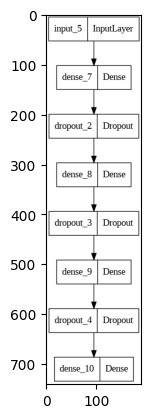

In [139]:
# Visualizing the model
plot_model(nn, to_file = "model.png")

data = plt.imread("model.png")
plt.imshow(data)
plt.show()

**Hyperparameter Tuning Using Keras Tuner**

**Source**: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [140]:
# Defining the Model function
def build_model(hp):
    model = keras.Sequential()

    # Input Layer
    model.add(keras.layers.Input(shape = (28 * 28, )))

    # Variable nr. of Hidden layers
    for i in range(hp.Int("num_layers", 1, 5)):
        units = hp.Int(f"units_{i}", min_value = 32, max_value = 256, step = 64)
        # Add Dropout regularization
        dropout_rate = hp.Float(f"dropout_{i}", min_value = 0.0, max_value = 0.5, step = 0.1)
        model.add(keras.layers.Dense(units = units, activation = "relu"))
        model.add(keras.layers.Dropout(dropout_rate))

    # Output Layer
    model.add(keras.layers.Dense(10, activation = "softmax"))

    # Model Compilation
    model.compile(optimizer = keras.optimizers.Adam(hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

    return model

In [141]:
# Initializing the Tuner
tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 3,
    directory = "my_dir",
    project_name = "fashion_mnist")

Reloading Tuner from my_dir/fashion_mnist/tuner0.json


In [142]:
# Fitting the Models (Takes approx. 12-15 min. on CPU)
tuner.search(X_train, y_train, epochs = 10, validation_split = 0.2, verbose = 0)

In [143]:
# Getting the Best Model and its Hyperparameters
best_model_nn = tuner.get_best_models(num_models = 1)[0]
best_hyperparams_nn = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [144]:
# Testing Accuracy
test_loss, test_accuracy = best_model_nn.evaluate(X_test, y_test)
test_accuracy

313/313 [==============================] - 1s 4ms/step - loss: 0.3480 - accuracy: 0.8750


0.875

- As we can see, the testing accuracy is pretty much the same to the Neural Network we obtained without rigorous hyperparameter tuning.
- More layers, regularization, and activation function options could be specified in the keras Tuner but this would take a very long time to run.

In [145]:
tuner.results_summary()

Results summary
Results in my_dir/fashion_mnist
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_layers: 1
units_0: 224
dropout_0: 0.4
learning_rate: 0.001
units_1: 32
dropout_1: 0.2
units_2: 32
dropout_2: 0.4
Score: 0.8840277791023254

Trial 03 summary
Hyperparameters:
num_layers: 1
units_0: 32
dropout_0: 0.0
learning_rate: 0.001
units_1: 224
dropout_1: 0.2
units_2: 32
dropout_2: 0.1
Score: 0.8775277932484945

Trial 04 summary
Hyperparameters:
num_layers: 1
units_0: 96
dropout_0: 0.0
learning_rate: 0.01
units_1: 224
dropout_1: 0.1
units_2: 160
dropout_2: 0.2
Score: 0.8585833311080933

Trial 06 summary
Hyperparameters:
num_layers: 1
units_0: 32
dropout_0: 0.1
learning_rate: 0.0001
units_1: 160
dropout_1: 0.4
units_2: 224
dropout_2: 0.0
Score: 0.8560000061988831

Trial 00 summary
Hyperparameters:
num_layers: 3
units_0: 96
dropout_0: 0.2
learning_rate: 0.01
units_1: 32
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
Score: 0.85186109

### 6.2. Convolutional Neural Network

Since we are dealing with image classification, it is advisable to use convolutional neural networks. This is because they are especially great in tasks relating to images.
They also require way less training data to work with than regular feedforward neural networks.

Preprocessing:

In [146]:
# Converting the images to a 3D tensor of dimensions 28x28x1 (required for convolutional networks)
X_train = X_train.reshape((train_size, 28, 28, 1))
X_test = X_test.reshape((test_size, 28, 28, 1))

Because the fitting of a convolutional network already took 10 minutes, applying keras tuner to tune the hyperparameters would take a really long time. For this reason, I have decided to tune the hyperparameters by hand and testing a few architectures. In all architectures, I went for the "relu" activation function as it works the best and a "softmax" activation function for the output layer. I have also always applied pooling layer of size = 2 and convolutional layers with kernel size = 3. Specifically, I have tested these architectures:

- 1) 3 convolutional layers with the nr. of filters (32, 64, 128) and 2 pooling layers in between them
- 2) 5 convolutional layers with the nr. of filters (32, 64, 128, 256, 512) and 4 pooling layers in between them
- 3) 5 convolutional layers with the nr. of filters (8, 16, 32, 64, 128) and 4 pooling layers in between them and a Dropout layer (0.4)

The first option worked the best, so I am including it here:

Model Specification:

In [147]:
inputs = keras.Input(shape = (28, 28, 1))
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(inputs)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation = "softmax")(x)

model_conv = keras.Model(inputs = inputs, outputs = outputs)

Model Compilation:

In [148]:
# We should use "categorical_crossentropy" loss function for classification models !!!
# using "categorical_crossentropy" also suggests that the target labels should be in one-hot encoded format (done using "to_categorical()") !!!
model_conv.compile(optimizer = "adam",
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"])
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

Fitting the Model:

In [149]:
# Takes approx. 8-10 min. on CPU
epochs = 10
batch_size = 128
results_conv = model_conv.fit(X_train, y_train,
                epochs = epochs,
                batch_size = batch_size,
                validation_split = 0.2)

Epoch 1/10
375/375 [==============================] - 45s 116ms/step - loss: 0.6211 - accuracy: 0.7769 - val_loss: 0.4334 - val_accuracy: 0.8454
Epoch 2/10
375/375 [==============================] - 45s 121ms/step - loss: 0.3860 - accuracy: 0.8616 - val_loss: 0.3533 - val_accuracy: 0.8749
Epoch 3/10
375/375 [==============================] - 43s 115ms/step - loss: 0.3286 - accuracy: 0.8810 - val_loss: 0.3278 - val_accuracy: 0.8808
Epoch 4/10
375/375 [==============================] - 44s 117ms/step - loss: 0.2989 - accuracy: 0.8905 - val_loss: 0.3210 - val_accuracy: 0.8838
Epoch 5/10
375/375 [==============================] - 43s 116ms/step - loss: 0.2770 - accuracy: 0.8993 - val_loss: 0.2925 - val_accuracy: 0.8942
Epoch 6/10
375/375 [==============================] - 43s 115ms/step - loss: 0.2587 - accuracy: 0.9054 - val_loss: 0.2963 - val_accuracy: 0.8956
Epoch 7/10
375/375 [==============================] - 43s 115ms/step - loss: 0.2429 - accuracy: 0.9110 - val_loss: 0.2760 - val_ac

Model Accuracy:

In [150]:
train_accuracy_conv = results_conv.history["accuracy"][-1]  # Getting the Training accuracy
test_loss_conv, test_accuracy_conv = model_conv.evaluate(X_test, y_test)  # Getting the Testing accuracy
print(f"Training accuracy of the Convolutional Neural Network is {np.round(train_accuracy_conv, 4)}")
print(f"Testing accuracy of the Convolutional Neural Network is {np.round(test_accuracy_conv, 4)}")

313/313 [==============================] - 3s 9ms/step - loss: 0.2740 - accuracy: 0.9033
Training accuracy of the Convolutional Neural Network is 0.9264
Testing accuracy of the Convolutional Neural Network is 0.9033


Visualising...

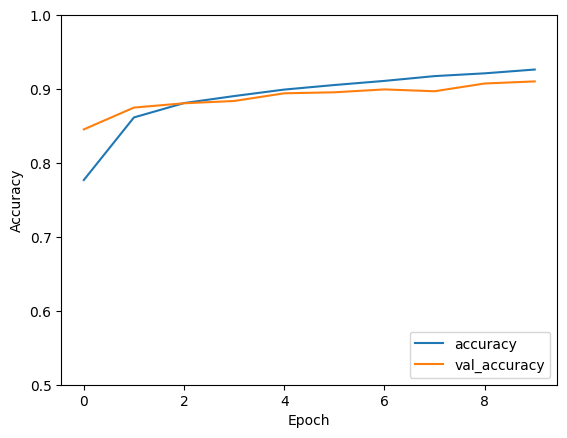

In [151]:
plt.plot(results_conv.history["accuracy"], label = "accuracy")
plt.plot(results_conv.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc = "lower right")

Model Predictions:

In [152]:
test_images = X_test.reshape((-1, 28, 28, 1))
predictions_conv = model_conv.predict(test_images) # Gives predictions for all the images in the test set
predictions_conv[0] # Gives probabilities that the first testing image belongs to class 1, to class 2, ..., to class 10

313/313 [==============================] - 4s 13ms/step


array([1.3151179e-06, 5.5697197e-10, 4.7420265e-08, 1.5641624e-09,
       4.3299234e-10, 1.5350936e-04, 2.1229226e-08, 1.9901844e-03,
       4.8180704e-05, 9.9780679e-01], dtype=float32)

In [153]:
# The highest probability of the 10 output nodes belongs to...
label = predictions_conv[0].argmax()
label

9

Now, saving the model:

In [154]:
model_conv.save("Convolutional_Neural_Network")            # Saving the model architecture
model_conv.save_weights("Convolutional_Neural_Network.h5") # Saving the trained weights

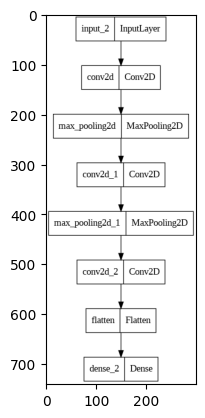

In [155]:
# Plotting the model
plot_model(model_conv, to_file = "model.png")

data = plt.imread("model.png")
plt.imshow(data)
plt.show()

### 6.3. Convolutional Neural Network with Data Augmentation and Dropout Regularization

Data Augmentation is a useful technique when we have fewer data. It generates more training data by many random transformations such as random flipping of the image, random rotation, random zooming, etc.

It is especially good for image data.

This technique helps tackle overfitting and it is good to use it in conjunction with the Dropout regularization.

In [156]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Preprocessing:

In [157]:
# Converting the images to a 3D tensor of dimensions 28x28x1 (required for convolutional networks)
X_train = X_train.reshape((train_size, 28, 28, 1))
X_test = X_test.reshape((test_size, 28, 28, 1))

Because the fitting of a convolutional network already took 10 minutes, applying keras tuner to tune the hyperparameters would take a really long time. For this reason, I have decided to tune the hyperparameters by hand and testing a few architectures. In all architectures, I went for the "relu" activation function as it works the best and a "softmax" activation function for the output layer. I have also always applied pooling layer of size = 2 and convolutional layers with kernel size = 3. Specifically, I have tested these architectures:

- 1) 3 convolutional layers with the nr. of filters (32, 64, 128) and 2 pooling layers in between them
- 2) 5 convolutional layers with the nr. of filters (32, 64, 128, 256, 512) and 4 pooling layers in between them
- 3) 5 convolutional layers with the nr. of filters (8, 16, 32, 64, 128) and 4 pooling layers in between them and a Dropout layer (0.4)

The first option worked the best, so I am including it here:

Model Specification:

In [158]:
inputs = keras.Input(shape = (28, 28, 1))

# Data Augmentation Layer
x = data_augmentation(inputs)

# Remaining Layers are the same as before
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)

# Also adding the Dropout Regularization
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation = "softmax")(x)
model_aug = keras.Model(inputs = inputs, outputs = outputs)

Model Compilation:

In [159]:
# We should use "categorical_crossentropy" loss function for classification models !!!
# using "categorical_crossentropy" also suggests that the target labels should be in one-hot encoded format (done using "to_categorical()") !!!
model_aug.compile(optimizer = "adam",
                   loss = "categorical_crossentropy",
                   metrics = ["accuracy"])
model_aug.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                      

Fitting the Model:

In [160]:
# Takes approx. 8-10 min. on CPU
epochs = 10
batch_size = 128
early_stopping_monitor = EarlyStopping(monitor = "accuracy", patience = 2)
results_aug = model_aug.fit(X_train, y_train,
              epochs = epochs,
              batch_size = batch_size,
              validation_split = 0.2,
              callbacks = [early_stopping_monitor])

Epoch 1/10
375/375 [==============================] - 48s 125ms/step - loss: 0.9994 - accuracy: 0.6350 - val_loss: 0.6561 - val_accuracy: 0.7413
Epoch 2/10
375/375 [==============================] - 50s 134ms/step - loss: 0.6956 - accuracy: 0.7409 - val_loss: 0.6821 - val_accuracy: 0.7364
Epoch 3/10
375/375 [==============================] - 47s 125ms/step - loss: 0.6317 - accuracy: 0.7668 - val_loss: 0.5314 - val_accuracy: 0.8026
Epoch 4/10
375/375 [==============================] - 48s 128ms/step - loss: 0.5909 - accuracy: 0.7816 - val_loss: 0.5394 - val_accuracy: 0.8023
Epoch 5/10
375/375 [==============================] - 47s 124ms/step - loss: 0.5635 - accuracy: 0.7925 - val_loss: 0.4883 - val_accuracy: 0.8205
Epoch 6/10
375/375 [==============================] - 46s 124ms/step - loss: 0.5445 - accuracy: 0.8008 - val_loss: 0.5033 - val_accuracy: 0.8135
Epoch 7/10
375/375 [==============================] - 48s 129ms/step - loss: 0.5204 - accuracy: 0.8086 - val_loss: 0.5100 - val_ac

Model Accuracy:

In [161]:
train_accuracy_conv_dataaugmented = results_aug.history["accuracy"][-1]  # Getting the Training accuracy
test_loss_conv_dataaugmented, test_accuracy_conv_dataaugmented = model_aug.evaluate(X_test, y_test)  # Getting the Testing accuracy
print(f"Training accuracy of the Convolutional Neural Network with Data Augmentation is {np.round(train_accuracy_conv_dataaugmented, 4)}")
print(f"Testing accuracy of the Convolutional Neural Network with Data Augmentation is {np.round(test_accuracy_conv_dataaugmented, 4)}")

313/313 [==============================] - 3s 10ms/step - loss: 0.4520 - accuracy: 0.8366
Training accuracy of the Convolutional Neural Network with Data Augmentation is 0.822
Testing accuracy of the Convolutional Neural Network with Data Augmentation is 0.8366


We can see that Data Augmentation did not actually help our dataset at all, it actually decreased the accuracy.

Model Predictions:

In [162]:
test_images = X_test.reshape((-1, 28, 28, 1))
predictions_conv_dataaugmented = model_aug.predict(test_images) # Gives predictions for all the images in the test set
predictions_conv_dataaugmented[0] # Gives probabilities that the first testing image belongs to class 1, to class 2, ..., to class 10

313/313 [==============================] - 4s 14ms/step


array([5.8200402e-07, 1.4404723e-08, 1.9907326e-07, 6.3228953e-08,
       1.4729420e-07, 4.2467467e-03, 1.5949192e-07, 1.1985978e-02,
       3.3397559e-05, 9.8373258e-01], dtype=float32)

In [163]:
# The highest probability of the 10 output nodes belongs to...
label = predictions_conv_dataaugmented[0].argmax()
label

9

Now, saving the model:

In [164]:
model_aug.save("Conv_DataAugmented_Neural_Network")            # Saving the model architecture
model_aug.save_weights("Conv_DataAugmented_Neural_Network.h5") # Saving the trained weights

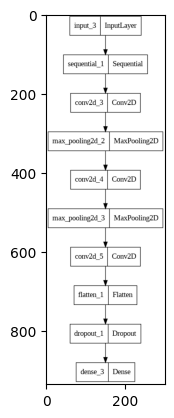

In [165]:
# Plotting the model
plot_model(model_aug, to_file = "model.png")

data = plt.imread("model.png")
plt.imshow(data)
plt.show()

### 6.4. Experiment with fewer training data

We will be including only the first 1000 pictures out of the total 60000 for training now. This should reduce the accuracies of the neural networks but the accuracy of the convolutional neural network should decrease by only a little bit as they are great even with small amount of training data.

In [166]:
# X_train = X_train[:1000]
# y_train = y_train[:1000]

- I ran this experiment (uncommented the code above after loading the dataset) but for the sake of a cleaner code and the fact that it would take a long time to run the entire code again, I will only be including the results and comparing them with the initial results.

## 7. Model Comparison and Conclusion

a) When using the full 60000 training images:

In [167]:
data = {
    "FeedForward NN": [train_accuracy_feedforward, test_accuracy_feedforward],
    "Convolutional NN": [train_accuracy_conv, test_accuracy_conv],
    "Convolutional NN with Data Aug.": [train_accuracy_conv_dataaugmented, test_accuracy_conv_dataaugmented]
       }
index_names = ["Training score", "Testing score"]

df = pd.DataFrame(data, index = index_names)
df

,FeedForward NN,Convolutional NN,Convolutional NN with Data Aug.
Training score,0.8855,0.926396,0.822021
Testing score,0.8797,0.903300,0.836600


- The standard feedforward neural networks yield an excellent result of almost 88% on testing data
- However, the simple Convolutional Neural Network outperformed the feedforward network as expected, yielding the best result of 90.3% on testing data.
- Data Augmentation has surprisingly been more detrimental than helpful for this dataset (maybe because we are not dealing with 3D pictures)
- There is generally very little overfitting, however in case of simple convolutional neural networks, this overfitting is a bit higher

b) When only using the first 1000 images for training:

- My proposed feedforward neural network architectures worked worse with only 77% testing accuracy
- However, when applying keras tuner on it, the accuracy increased to a whopping 87.5% testing accuracy
- Surprisingly, the convolutional networks did not work as well with little data with only a 73.9% testing accuracy
- Lastly, data augmentation did not help once again, resulting in only a 67% testing accuracy

In [168]:
data = {
    "FeedForward NN": [0.791, 0.774],
    "FeedForward NN using Keras Tuner": [0.892, 0.875],
    "Convolutional NN": [0.79375, 0.73940],
    "Convolutional NN with Data Aug.": [0.59625, 0.67020]
       }
index_names = ["Training score", "Testing score"]

df_experiment = pd.DataFrame(data, index = index_names)
df_experiment

,FeedForward NN,FeedForward NN using Keras Tuner,Convolutional NN,Convolutional NN with Data Aug.
Training score,0.791,0.892,0.79375,0.59625
Testing score,0.774,0.875,0.73940,0.67020


## 8. Souvislost s jinými semestrálními, případně kvalifikačními, pracemi zpracovávanými v minulosti nebo souběžně

Tato semestrální práce nemá textový ani věcný překryv, ani jinou věcnou souvislost, s jinými semestrálními nebo kvalifikačními pracemi, které jsem zpracovával.